In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Load the data set and get the parameters and labels 

In [2]:
temperature_data = pd.read_csv('./data/toronto_temperature.csv')

In [3]:
temperature_data.head(5)

,dt_iso,temp
0,2023-05-17 00:00:00+00:00,15.14
1,2023-05-17 01:00:00+00:00,12.97
2,2023-05-17 02:00:00+00:00,11.63
3,2023-05-17 03:00:00+00:00,10.07
4,2023-05-17 04:00:00+00:00,8.97


In [4]:
training_set = temperature_data.iloc[:, 1:2].values

In [5]:
training_set

array([[15.14],
       [12.97],
       [11.63],
       ...,
       [17.34],
       [17.  ],
       [17.67]])

In [6]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [7]:
# Creating a data structure with 168 timesteps and 1 output
# The number 168 is taken because the temperature data is hourly, meaning a day have 24 samples
# For 1 weeks for each step the amount would be calculated 7 * 24 = 168
x_train = []
y_train = []
for i in range(168, len(training_set)):
    x_train.append(training_set_scaled[i-168:i, 0])
    y_train.append(training_set_scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

# Get test data
x_test = x_train[7000:7050, :]
y_test = y_train[7000:7050]

#Trim the data, reduce the size of the training sets
x_train = x_train[0:7000, :]
y_train = y_train[0:7000]

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
seq_length = 10
X, y = create_sequences(training_set_scaled, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))
# Get test data
x2_test = X[7000:7050, :]
y2_test = y[7000:7050]

#Trim the data, reduce the size of the training sets
x2_train = X[0:7000, :]
y2_train = y[0:7000]

# Preparing the model and building the model

In [12]:
# Model is created, for this case, an LSTM with 84 unit is added with dropout set at 20% of the network
model = Sequential()

#First layer
model.add(LSTM(units = 55, activation="relu" , return_sequences = True, input_shape = (x2_train.shape[1], 1)))
model.add(Dropout(0.2))

#Second Layer
#model.add(LSTM(units = 120, return_sequences = True))
#model.add(Dropout(0.2))

#Thrid Layer
#model.add(LSTM(units = 120, return_sequences = True))
#model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Optimizer and Compiling model
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer = optimizer, loss = 'mse', metrics = ['accuracy'])

In [14]:
# Training the model
checkpoint_cb = ModelCheckpoint("./Toronto_Temperature_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(x2_train, y2_train, epochs = 100,batch_size = 32, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
219/219 [==============================] - 3s 4ms/step - loss: 0.0726 - accuracy: 1.4286e-04
Epoch 2/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0180 - accuracy: 2.7143e-04
Epoch 3/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0112 - accuracy: 2.7143e-04
Epoch 4/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0093 - accuracy: 2.8571e-04
Epoch 5/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0084 - accuracy: 2.8571e-04
Epoch 6/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0078 - accuracy: 2.8571e-04
Epoch 7/100
219/219 [==============================] - 1s 5ms/step - loss: 0.0073 - accuracy: 2.8571e-04
Epoch 8/100
219/219 [==============================] - 2s 7ms/step - loss: 0.0069 - accuracy: 2.8571e-04
Epoch 9/100
219/219 [==============================] - 1s 6ms/step - loss: 0.0066 - accuracy: 2.8571e-04
Epoch 10/100
219/219 [==============================] -

In [ ]:
model.save("./Toronto_Temperature_model.keras")

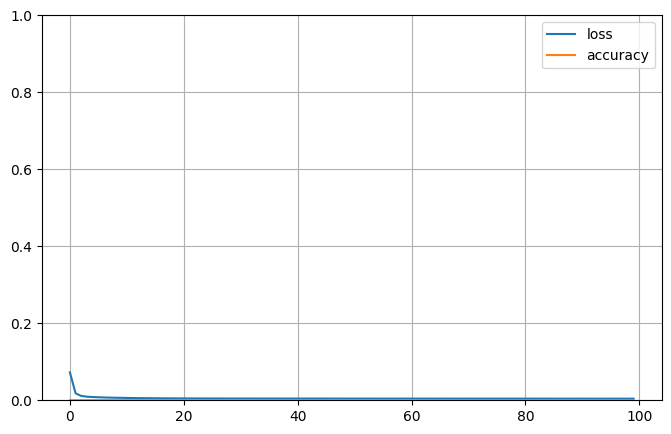

In [15]:
#Evaluate the results
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [17]:
# Evaluate 
model.evaluate(x2_train, y2_train)

219/219 [==============================] - 1s 3ms/step - loss: 0.0033 - accuracy: 2.8571e-04


[0.003280702279880643, 0.0002857142826542258]

In [19]:
def predict_future(model, data, sequence_length, steps):
    current_sequence = data[-sequence_length:]
    future_predictions = []
    
    for _ in range(steps):
        current_sequence = current_sequence.reshape((1, sequence_length, 1))
        prediction = model.predict(current_sequence, verbose=0)
        future_predictions.append(prediction[0, 0])
        current_sequence = np.append(current_sequence[0, 1:], prediction, axis=0)
    
    return future_predictions
future_steps = 10

future_predictions = predict_future(model, x2_test, seq_length, future_steps)

ValueError: cannot reshape array of size 100 into shape (1,10,1)